In [1]:
import os
os.chdir('D:/EPFL/ML/projects/nerve-segmentation/')
print(os.getcwd())

D:\EPFL\ML\projects\nerve-segmentation


In [2]:
import numpy as np
from tensorflow import keras
import math
import random
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table
from tensorflow import keras

from src.eval import get_model_prediction

In [3]:
def get_samples(data_folder, test=False, num_samples=1, shuffle=True):
    img_folder = data_folder + '/images/rescaled'
    img_paths = [img_folder + '/' + img_file for img_file in os.listdir(img_folder)]
    if not test:
        mask_folder = data_folder + '/masks/rescaled'
        mask_paths = [mask_folder + '/' + mask_file for mask_file in os.listdir(mask_folder)]
    
        paths = list(zip(img_paths, mask_paths))
        if shuffle:
            random.shuffle(paths)
    else:
        paths = img_paths
        
    if num_samples == -1:
        num_samples = len(paths)
    return paths[:num_samples]

In [4]:
def calculate_iou(pred, mask):
    iou = keras.metrics.MeanIoU(num_classes=2)
    iou.update_state(pred, mask)
    iou_score = np.round(iou.result().numpy(), decimals=2)
    
def calculate_regions(pred, mask=None):
    regions_pred = regionprops(label(((1 - pred) * 255).astype(int)))
    regions_pred = [x for x in regions_pred if x.area > 15]
    
    if mask is not None:
        regions_mask = regionprops(label(((1 - mask) * 255).astype(int)))
        return (regions_pred, regions_mask)
    else:
        return (regions_pred, None)

In [5]:
def show_prediction(img_path, trained_model_checkpoint=None, save=False, show=True):
    if trained_model_checkpoint is not None:
        trained_model = keras.models.load_model(trained_model_checkpoint)
        
    img = np.load(img_path)
    pred = get_model_prediction(trained_model, np.expand_dims(img, axis=0))[0, :, :]
    
    if save:
        output_folder = os.path.join(os.getcwd(), 'results/visualisations/prediction')
        os.makedirs(output_folder, exist_ok=True)
        fname = img_path.rsplit('/', 1)[-1].rsplit('.', 1)[0]
        out_fname = os.path.join(output_folder, fname)
    
    fig, axs = plt.subplots(1,3, figsize=(12, 12))
    axs[0].imshow(img)
    axs[0].set_title('Original image')
    axs[1].imshow(pred, cmap = 'gray', interpolation = 'none')
    axs[1].set_title('Predicted fascicles')
    axs[2].imshow(img)
    axs[2].imshow(pred, cmap = 'gray', alpha = 0.3,interpolation = 'none')
    axs[2].set_title('Predicted fascicles overlayed \nonto the original image')
    
    if save:
        plt.savefig(out_fname + '_predicted.jpg')
    if show:
        plt.show()

In [6]:
def show_mask_and_prediction(img_path, mask_path, trained_model_checkpoint=None, save=False, show=True):
    if trained_model_checkpoint is not None:
        trained_model = keras.models.load_model(trained_model_checkpoint)
    
    if save:
        output_folder = os.path.join(os.getcwd(), 'results/visualisations/prediction_with_mask')
        os.makedirs(output_folder, exist_ok=True)
        fname = img_path.rsplit('/', 1)[-1].rsplit('.', 1)[0]
        out_fname = os.path.join(output_folder, fname)
    
    img = np.load(img_path)
    mask = np.load(mask_path)
    pred = get_model_prediction(trained_model, np.expand_dims(img, axis=0))[0, :, :]
    
    regions_pred, regions_mask = calculate_regions(pred, mask)
    areas_mask = [m.area for m in regions_mask]
    areas_pred = [p.area for p in regions_pred]
    
    fig, axs = plt.subplots(2,3, figsize=(12, 8))
    axs[0][0].imshow(img)
    axs[0][0].set_title('Original image')
    axs[0][1].imshow(mask, cmap = 'gray', interpolation = 'none')
    axs[0][1].set_title('Ground truth - Num. fascicles: {}'.format(len(regions_mask)))
    axs[0][2].imshow(pred, cmap = 'gray', interpolation = 'none')
    axs[0][2].set_title('Prediction - Num. fascicles: {}'.format(len(regions_pred)))
    
    axs[1][0].imshow(mask, cmap = 'gray', interpolation = 'none')
    axs[1][0].imshow(1 - pred, cmap = 'viridis', alpha=0.5,  interpolation = 'none')
    axs[1][0].set_title('Overlay prediction on ground truth')
    
    gs = axs[1][1].get_gridspec()
    
    for ax in axs[1][1:]:
        ax.remove()
    
    areas_ax = fig.add_subplot(gs[1, 1:])
    
    areas_ax.hist(areas_mask, bins=30, alpha=0.5, label='ground truth')
    areas_ax.hist(areas_pred, bins=30, alpha=0.5, label='prediction')
    areas_ax.legend(loc='upper right')
    areas_ax.set_xlabel('Areas (pixels)')
    areas_ax.set_ylabel('Frequency')
    areas_ax.set_title('Distribution of fascicles\' areas')
    
    if save:
        plt.savefig(out_fname + '_prediction_with_mask.jpg')
    if show:
        plt.show()

In [7]:
def show_fascicles_distribution(paths, test=False, trained_model_checkpoint=None, save=False, show=True):
    if trained_model_checkpoint is not None:
        trained_model = keras.models.load_model(trained_model_checkpoint)
    
    if save:
        output_folder = os.path.join(os.getcwd(), 'results/visualisations/distributions')
        os.makedirs(output_folder, exist_ok=True)
        if test:
            fname = 'Distribution for unlabelled test set'
        else:
            fname = 'Distribution for training set'
        out_fname = os.path.join(output_folder, fname)

    if not test:
        areas_mask = []
        num_fasicles_mask = []
    areas_pred = []
    num_fasicles_pred = []
    
    for p in paths:
        if not test:
            img_path, mask_path = p
            mask = np.load(mask_path)
        else:
            img_path = p
            mask = None
        
        img = np.load(img_path)
        pred = get_model_prediction(trained_model, np.expand_dims(img, axis=0))[0, :, :]
        
        regions_pred, regions_mask = calculate_regions(pred, mask)
        
        if not test:
            areas_mask = areas_mask + [m.area for m in regions_mask]
            num_fasicles_mask.append(len(regions_mask))
        areas_pred = areas_pred + [p.area for p in regions_pred]
        num_fasicles_pred.append(len(regions_pred))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    
    if not test:
        axs[0].hist(areas_mask, bins=50, alpha=0.5, label='ground truth')
        axs[1].hist(num_fasicles_mask, bins=30, alpha=0.5, label='ground truth')
    axs[0].hist(areas_pred, bins=50, alpha=0.5, label='prediction')
    axs[0].set_xlabel('Areas (pixels)')
    axs[0].set_ylabel('Frequency')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Distribution of Fascicles Areas')
    axs[1].hist(num_fasicles_pred, bins=30, alpha=0.5, label='prediction')
    axs[1].set_xlabel('Number of Fascicles')
    axs[1].set_ylabel('Frequency')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Distribution of Number of Fascicles')
    
    if save:
        plt.savefig(out_fname + '_predicted.jpg')
    if show:
        plt.show()

In [8]:
model_save_file = os.path.join(os.getcwd(), 'model_checkpoints/transforms512.h5')
train_folder = os.path.join(os.getcwd(), 'data/vagus_dataset/train')
unlabelled_folder = os.path.join(os.getcwd(), 'data/vagus_dataset/unlabelled')

sample_1 = get_samples(unlabelled_folder, test=True)
sample_2 = get_samples(train_folder, num_samples=3)
sample_3 = get_samples(train_folder, num_samples=-1)
sample_4 = get_samples(unlabelled_folder, test=True, num_samples=-1)

In [9]:
len(sample_4)

800

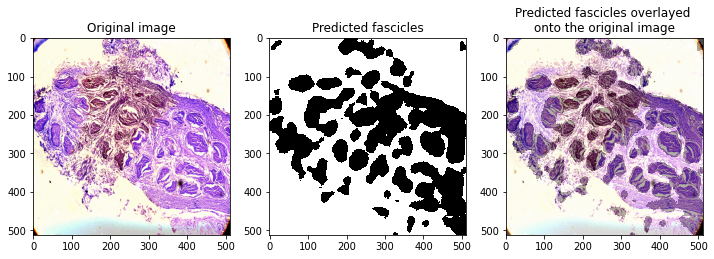

In [10]:
show_prediction(sample_1[0], trained_model_checkpoint=model_save_file, save=True)

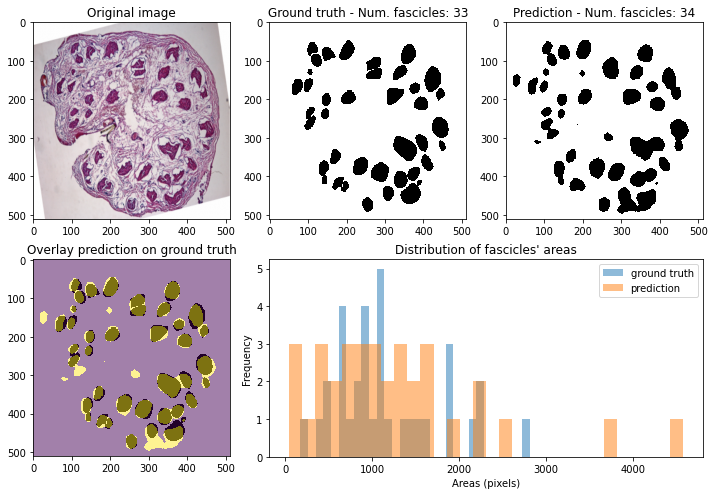

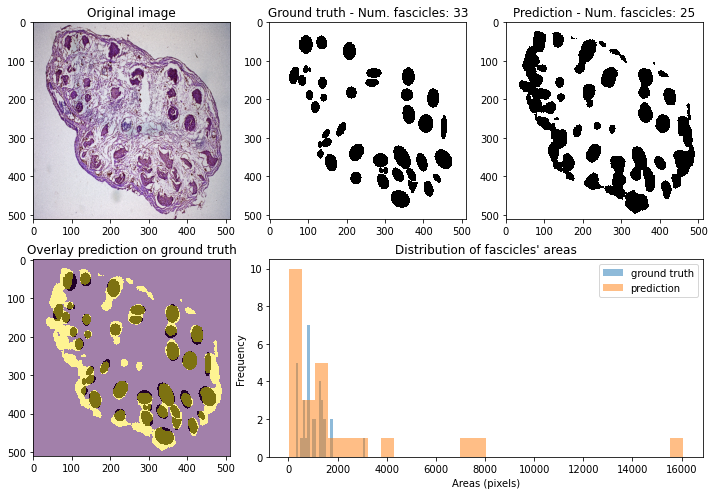

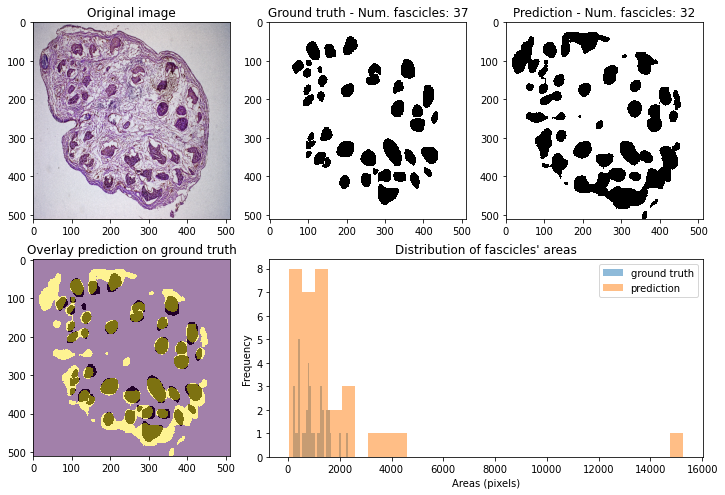

In [11]:
for (img, mask) in sample_2:
    show_mask_and_prediction(img, mask, trained_model_checkpoint=model_save_file, save=True)

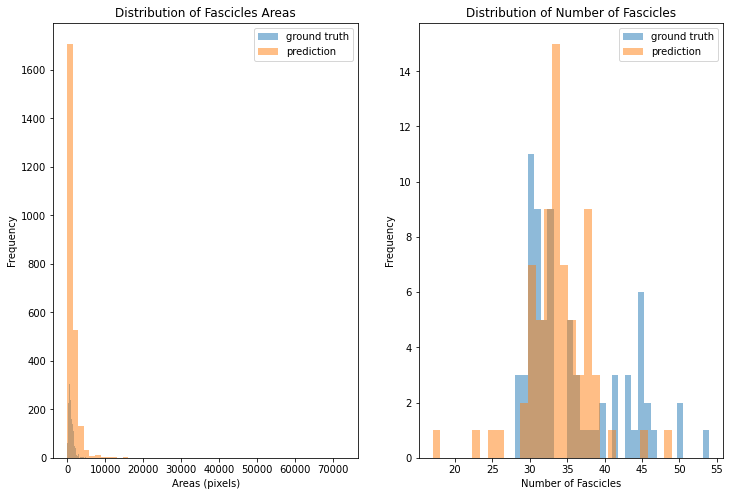

In [12]:
show_fascicles_distribution(sample_3, trained_model_checkpoint=model_save_file, save=True)

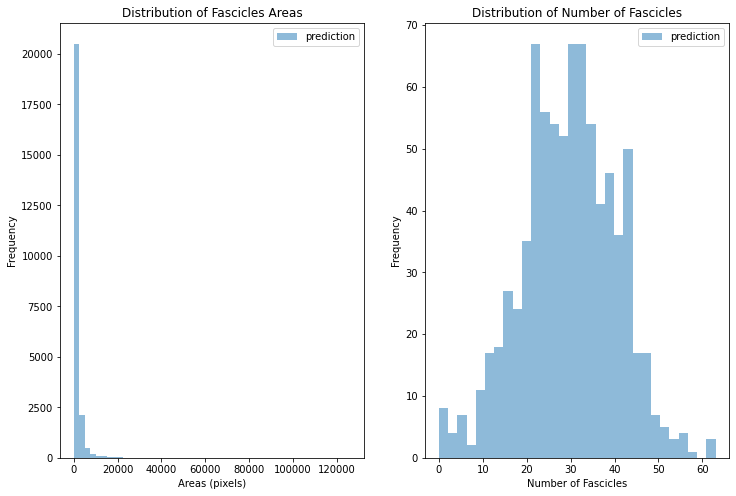

In [13]:
show_fascicles_distribution(sample_4, test=True, trained_model_checkpoint=model_save_file, save=True)

### Steps below is testing

In [14]:
a = show_distribution(imgpath, model_save_file)

NameError: name 'show_distribution' is not defined

In [ ]:
from skimage.measure import label, regionprops
from skimage import feature

In [ ]:
regions = regionprops(label(a))

In [ ]:
pred = ((1 - a) * 255).astype(int)

In [ ]:
regions_ = regionprops(label(pred))

In [ ]:
plt.imshow(a, cmap='gray')
for props in regions_:
    y0, x0 = props.centroid
    orientation = math.pi /2 - props.orientation
    theta = np.linspace(0, 2*math.pi, 100)
    x = x0 + 0.5 * props.major_axis_length * math.cos(orientation) * np.cos(theta) - 0.5 * props.minor_axis_length * math.sin(orientation) * np.sin(theta) 
    y = y0 + 0.5 * props.major_axis_length * math.sin(orientation) * np.cos(theta) + 0.5 * props.minor_axis_length * math.cos(orientation) * np.sin(theta)
    plt.plot(x, y, '-r', linewidth=1)
plt.show()

In [ ]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology

img = data.coins()
# Binary image, post-process the binary mask and compute labels
threshold = filters.threshold_otsu(img)
mask = img > threshold
mask = morphology.remove_small_objects(mask, 50)
mask = morphology.remove_small_holes(mask, 50)
labels = measure.label(mask)

In [ ]:
plt.imshow(label)